# TAPE Model with LGBM (data split by donor)

In [ ]:
# !conda install -c conda-forge lightgbm
# !pip install tape-proteins

In [1]:
from recipes.utils import get_03_data, get_all_combination_and_fill_nagatives, get_infer_report
import pandas as pd
import itertools
from tape import ProteinBertModel, TAPETokenizer
import torch
from multiprocessing import Pool
import os
import numpy as np
import pickle
import functools
import lightgbm
from lightgbm import LGBMClassifier

# Load data  

https://vdjdb.cdr3.net/search


In [ ]:
# !aws s3 cp  s3://sg-playground-kkoyama-temp/tcrpred/03.VDJdb.tsv ./data/ 

In [ ]:
df = get_03_data()

# Here, we assumed all the A and B pairs in a donor faced every EpiSeq at least once, and then created negative values.

In [ ]:
donor_dict = {d:df[df.Donor==d] for d in df.Donor.unique()}
data_all_by_donor = {d: get_all_combination_and_fill_nagatives(donor_dict[d]) for d in df.Donor.unique()}

for k, d in data_all_by_donor.items():
    d['Donor'] = k
    data_all_by_donor[k] = d

In [ ]:
for k, d in data_all_by_donor.items():
    print('--',k)
    print('df.shape',d.shape)
    print('df.interact.value_counts()', d.interact.value_counts().to_dict())
    print(f"df.interact pos ratio {(d.interact.value_counts()/len(d)).loc[1]:.3f}")
    

#### Add features from tape-model

In [ ]:
# model = ProteinBertModel.from_pretrained('bert-base')
# tokenizer = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model

# # @functools.lru_cache(100000)
# def get_feat_from_tape(sequence):
#     model.eval()
#     with torch.no_grad():
#         token_ids = torch.tensor([tokenizer.encode(sequence)])
#         output = model(token_ids)
#         sequence_output = output[0]
#         sequence_output.mean(dim=1)
#     return sequence_output.mean(dim=1)

# map_listEpiSeq = {}
# for seq in df['EpiSeq'].unique():
#     map_listEpiSeq[seq] = get_feat_from_tape(seq)

# map_listASeq = {}
# temp = df['ASeq'].unique()
# for seq in temp:
#     map_listASeq[seq] = get_feat_from_tape(seq)


# map_listBSeq = {}
# temp = df['BSeq'].unique()
# for seq in temp:
#     map_listBSeq[seq] = get_feat_from_tape(seq)


# map_listEpiSeq = {k:v.detach().cpu().numpy()[0] for k,v in map_listEpiSeq.items()}
# map_listASeq = {k:v.detach().cpu().numpy()[0] for k,v in map_listASeq.items()}
# map_listBSeq = {k:v.detach().cpu().numpy()[0] for k,v in map_listBSeq.items()}

# with open('map_listEpiSeq.pkl', 'wb') as pickle_out:
#     pickle.dump(map_listEpiSeq, pickle_out)
        
# with open('map_listASeq.pkl', 'wb') as pickle_out:
#     pickle.dump(map_listASeq, pickle_out)
    
# with open('map_listBSeq.pkl', 'wb') as pickle_out:
#     pickle.dump(map_listBSeq, pickle_out)

In [ ]:
map_listEpiSeq = pickle.load(open('map_listEpiSeq.pkl', 'rb'))
map_listASeq = pickle.load(open('map_listASeq.pkl', 'rb'))
map_listBSeq = pickle.load(open('map_listBSeq.pkl', 'rb'))

In [ ]:
df_map_listEpiSeq = pd.DataFrame.from_dict(map_listEpiSeq).T
df_map_listASeq = pd.DataFrame.from_dict(map_listASeq).T
df_map_listBSeq = pd.DataFrame.from_dict(map_listBSeq).T

df_map_listEpiSeq.columns = [f'episeq_{i}' for i in range( df_map_listEpiSeq.shape[1])]
df_map_listASeq.columns = [f'aseq_{i}' for i in range( df_map_listASeq.shape[1])]
df_map_listBSeq.columns = [f'bseq_{i}' for i in range( df_map_listBSeq.shape[1])]

df_map_listEpiSeq['EpiSeq'] = df_map_listEpiSeq.index.values
df_map_listASeq['ASeq'] = df_map_listASeq.index.values
df_map_listBSeq['BSeq'] = df_map_listBSeq.index.values

dfall = pd.concat([d for k,d in data_all_by_donor.items()])

## Model

In [ ]:
# dfpred_dict = {}

for TEST_DONOR in ['Donor1', 'Donor2', 'Donor3', 'Donor4']:
    
    dftrain = pd.concat([d for k,d in data_all_by_donor.items() if k!=TEST_DONOR])
    dftest = pd.concat([d for k,d in data_all_by_donor.items() if k==TEST_DONOR])

    print(dftrain.shape, dftest.shape)

    dftrain = pd.merge(dftrain, df_map_listEpiSeq, on='EpiSeq', how='left')
    dftrain = pd.merge(dftrain, df_map_listASeq, on='ASeq', how='left')
    dftrain = pd.merge(dftrain, df_map_listBSeq, on='BSeq', how='left')

    dftest = pd.merge(dftest, df_map_listEpiSeq, on='EpiSeq', how='left')
    dftest = pd.merge(dftest, df_map_listASeq, on='ASeq', how='left')
    dftest = pd.merge(dftest, df_map_listBSeq, on='BSeq', how='left')

    X_train = dftrain[[c for c in dftrain.columns if 'episeq' in c or 'aseq' in c or 'bseq' in c]]
    X_test = dftest[[c for c in dftest.columns if 'episeq' in c or 'aseq' in c or 'bseq' in c]]
    y_train = dftrain['interact'].values.ravel()
    y_test = ytrue = dftest['interact'].values.ravel()

    model = LGBMClassifier(is_unbalance=True)
    model.fit(X_train, y_train)

    ypred = model.predict_proba(X_test)
    ypred1 = ypred[:,1]

    dfpred = pd.DataFrame([ytrue, ypred1]).T
    dfpred.columns = ['true', 'pred']
    
    print(get_infer_report(ytrue, ypred1))

    dfpred.to_csv(f'dfpred_{TEST_DONOR}.csv',index=None)

--------------------------------------------------
TEST on  Donor1
- acc 0.9323798052795342
- balanced_acc 0.8439718291891591
- precision on 1:  0.3198503624035539
- precision on 0:  0.9899095261100619
- confusion matrix tn, fp, fn, tp: 90157, 5818, 919, 2736
- roc_auc_score 0.9333811066422122
- pr_auc_score on 1 0.4916665835826334
- pr_auc_score on 0 0.9961529691006039


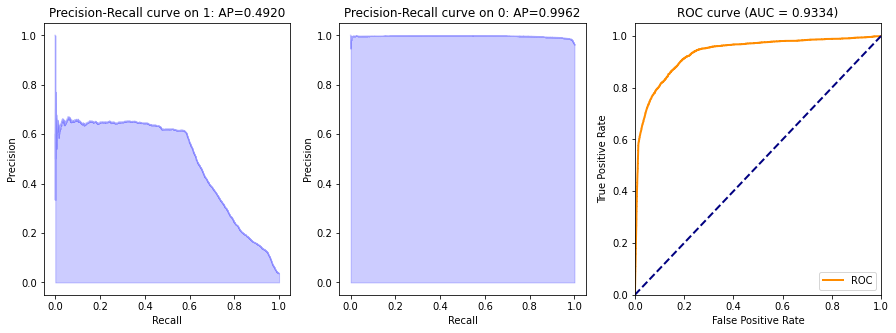

None
--------------------------------------------------
TEST on  Donor2
- acc 0.9207909455234069
- balanced_acc 0.7901594546761362
- precision on 1:  0.27998061076102765
- precision on 0:  0.9848285216043402
- confusion matrix tn, fp, fn, tp: 101654, 7427, 1566, 2888
- roc_auc_score 0.9193850425772303
- pr_auc_score on 1 0.3955213243328543
- pr_auc_score on 0 0.9960492863469779


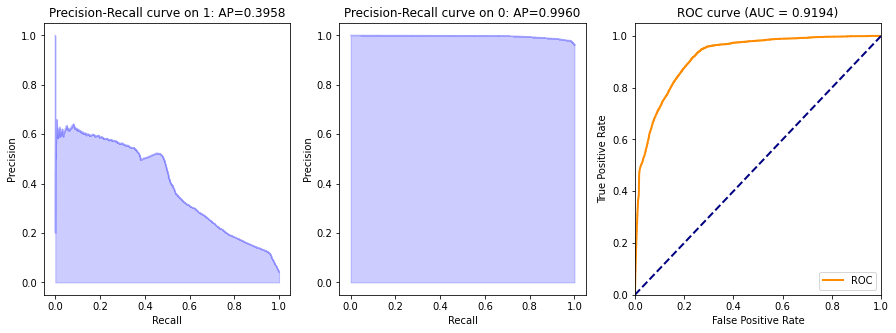

None
--------------------------------------------------
TEST on  Donor3
- acc 0.9079156082572573
- balanced_acc 0.9343902287539376
- precision on 1:  0.2471355422378361
- precision on 0:  0.998681608437706
- confusion matrix tn, fp, fn, tp: 316635, 32788, 418, 10763
- roc_auc_score 0.986848771046529
- pr_auc_score on 1 0.8535124431724739
- pr_auc_score on 0 0.9994603880614363


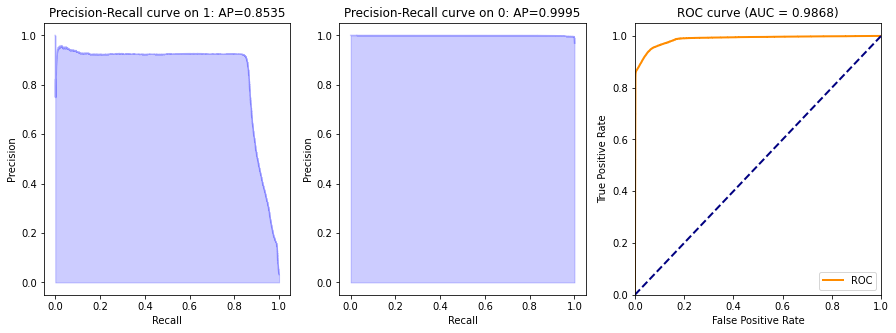

None
--------------------------------------------------
TEST on  Donor4
- acc 0.9260184097140619
- balanced_acc 0.8224201880497475
- precision on 1:  0.35170603674540685
- precision on 0:  0.9850963874939251
- confusion matrix tn, fp, fn, tp: 18243, 1235, 276, 670
- roc_auc_score 0.940230665181534
- pr_auc_score on 1 0.5749771663986786
- pr_auc_score on 0 0.9962729470432512


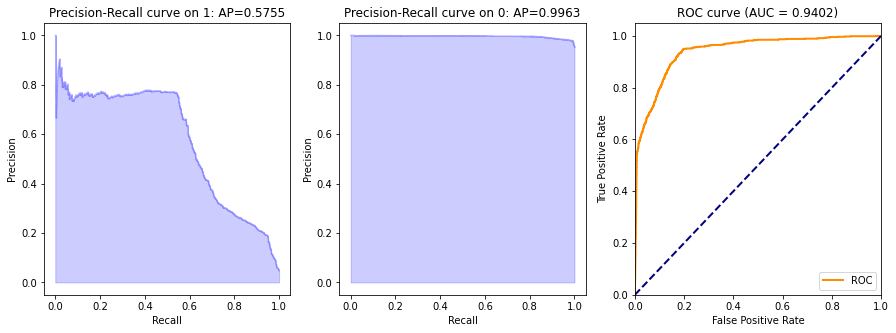

None


In [2]:
for TEST_DONOR in ['Donor1', 'Donor2', 'Donor3', 'Donor4']:
    print('-'*50)
    print('TEST on ', TEST_DONOR)
    fname = f'dfpred_{TEST_DONOR}.csv'
    true = pd.read_csv(fname)['true'].values
    pred = pd.read_csv(fname)['pred'].values
    print(get_infer_report(true, pred))